# This notebook is a holistic data science project covering the following steps and techniques: 
1. Data understanding & transformation including feature encoding, feature engineering as well as data visualization 
2. Outlier Detection with Isolation Forest and Z-Score
3. Handling class imbalance using SMOTE
4. Comparison of different ml models via k-fold cross validation
5. Hyperparameter optimization using GridSearch
6. Explainable and ethical AI with Shap


In [ ]:
pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import scipy.stats
from scipy import stats

import shap
import xgboost
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(10,7)})

In [ ]:
# let's load the dataset and drop the first irrelevant feature

data_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SMOTE/Kopie von WA_Fn-UseC_-HR-Employee-Attrition.csv")
data_raw = data_raw.drop('EmployeeNumber', axis =1) # won't have an influence on the target 
data_raw.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# 1: Data Understanding & Transformation
The overall goal of this part is to understand the data besides others in order to properly make the data digestable for ml algorithms via transformation as well as selecting the important features. The following steps are included:

1.   Data Understanding
2.   Data Transformation
3. Feature Engineering

#### 1.1 Data Understanding
Firstly, let's get an overview of all features with respect to their feature values, nans and datatype.

In [ ]:
# keep data_raw as it is for later exploratory data anaylsis approaches and proceed working and df
df = data_raw.copy()

column_dict = {}

for col in df.columns[0:]:
  column_dict[col] = [len(list(df[col].unique())), df[col].dtypes, df[col].isna().sum(), [i for i in df[col].unique()]]

column_info_df = pd.DataFrame(column_dict).transpose()
column_info_df.columns=["sum disinct values", "dtype", "NaNs", "disinct values"]
column_info_df.sort_values("sum disinct values", ascending=False)

,sum disinct values,dtype,NaNs,disinct values
MonthlyRate,1427,int64,0,"[19479, 24907, 2396, 23159, 16632, 11864, 9964..."
MonthlyIncome,1349,int64,0,"[5993, 5130, 2090, 2909, 3468, 3068, 2670, 269..."
DailyRate,886,int64,0,"[1102, 279, 1373, 1392, 591, 1005, 1324, 1358,..."
HourlyRate,71,int64,0,"[94, 61, 92, 56, 40, 79, 81, 67, 44, 84, 49, 3..."
Age,43,int64,0,"[41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 2..."
TotalWorkingYears,40,int64,0,"[8, 10, 7, 6, 12, 1, 17, 5, 3, 31, 13, 0, 26, ..."
YearsAtCompany,37,int64,0,"[6, 10, 0, 8, 2, 7, 1, 9, 5, 4, 25, 3, 12, 14,..."
DistanceFromHome,29,int64,0,"[1, 8, 2, 3, 24, 23, 27, 16, 15, 26, 19, 21, 5..."
YearsInCurrentRole,19,int64,0,"[4, 7, 0, 2, 5, 9, 8, 3, 6, 13, 1, 15, 14, 16,..."
YearsWithCurrManager,18,int64,0,"[5, 7, 0, 2, 6, 8, 3, 11, 17, 1, 4, 12, 9, 10,..."


#### Key-findings: There are four types of features which will be handeld individually
1. Columns with only one unique value will be dropped, since they don't contain information
2. Binary featuers where LabelEncoder will be applied
3. Feature with multiple categories which will be onehot encoded
4. Numerical feature which will be scaled

#### 1.2 Data Transformation
Firstly, assign the columns to the three buckets according to their feature type (binary, categorical, numerical) and then apply the respective transformation per bucket. 

In [ ]:
# drop columns with only one unique value
df = df.drop(["EmployeeCount", "Over18", "StandardHours"], axis = 1)

label_cols = ['Attrition', 'Gender', 'OverTime'] # label encoder
cat_cols = ['BusinessTravel', 'Department', 'EducationField',  'JobRole', 'MaritalStatus'] # onehot encoder
num_cols = [i for i in df.columns if i not in label_cols and i not in cat_cols] # standard scaler 

In [ ]:
# Application of transofrmation
# Label Encoder
label_enc = LabelEncoder()
for i in label_cols:
  df[i] = label_enc.fit_transform(df[[i]])

# OneHotEncoder
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# StandardsScaler
standard_scaler = StandardScaler()
df[num_cols] = standard_scaler.fit_transform(df[num_cols])

df.head()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,0.446350,1,0.742527,-1.010909,-0.891688,-0.660531,0,1.383138,0.379672,-0.057788,1.153254,-0.108350,0.726020,2.125136,1,-1.150554,-0.426230,-1.584178,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,1.322365,0,-1.297775,-0.147150,-1.868426,0.254625,1,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,1.488876,-0.678049,0,2.129306,2.346151,1.191438,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0.008343,1,1.414363,-0.887515,-0.891688,1.169781,1,1.284725,-1.026167,-0.961486,0.246200,-0.937654,-1.674841,1.324226,1,-0.057267,-0.426230,-0.658973,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,-0.429664,0,1.461466,-0.764121,1.061787,1.169781,0,-0.486709,0.379672,-0.961486,0.246200,-0.763634,1.243211,-0.678049,1,-1.150554,-0.426230,0.266233,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,-1.086676,0,-0.524295,-0.887515,-1.868426,-1.575686,1,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,0.325900,2.525591,0,-0.877232,-0.426230,1.191438,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0


Exploratory Data Analysis (EDA) helps to deeply understand the data and includes techniques like: 
1. Correlation Analysis
2. Distribution Analysis

One exapmle could be that two features highly correlate since they have the same information. Also one features might has several outliers, which probably decrease the ml model performance. In this case the EDA comes after data transformation. Sometimes you do it beforehand, however, in this case some categorical columns could be analyzed.

In [ ]:
# first, let's see how many data points per class exist

df.Attrition.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

The class imbalance will be handeled in the third section.

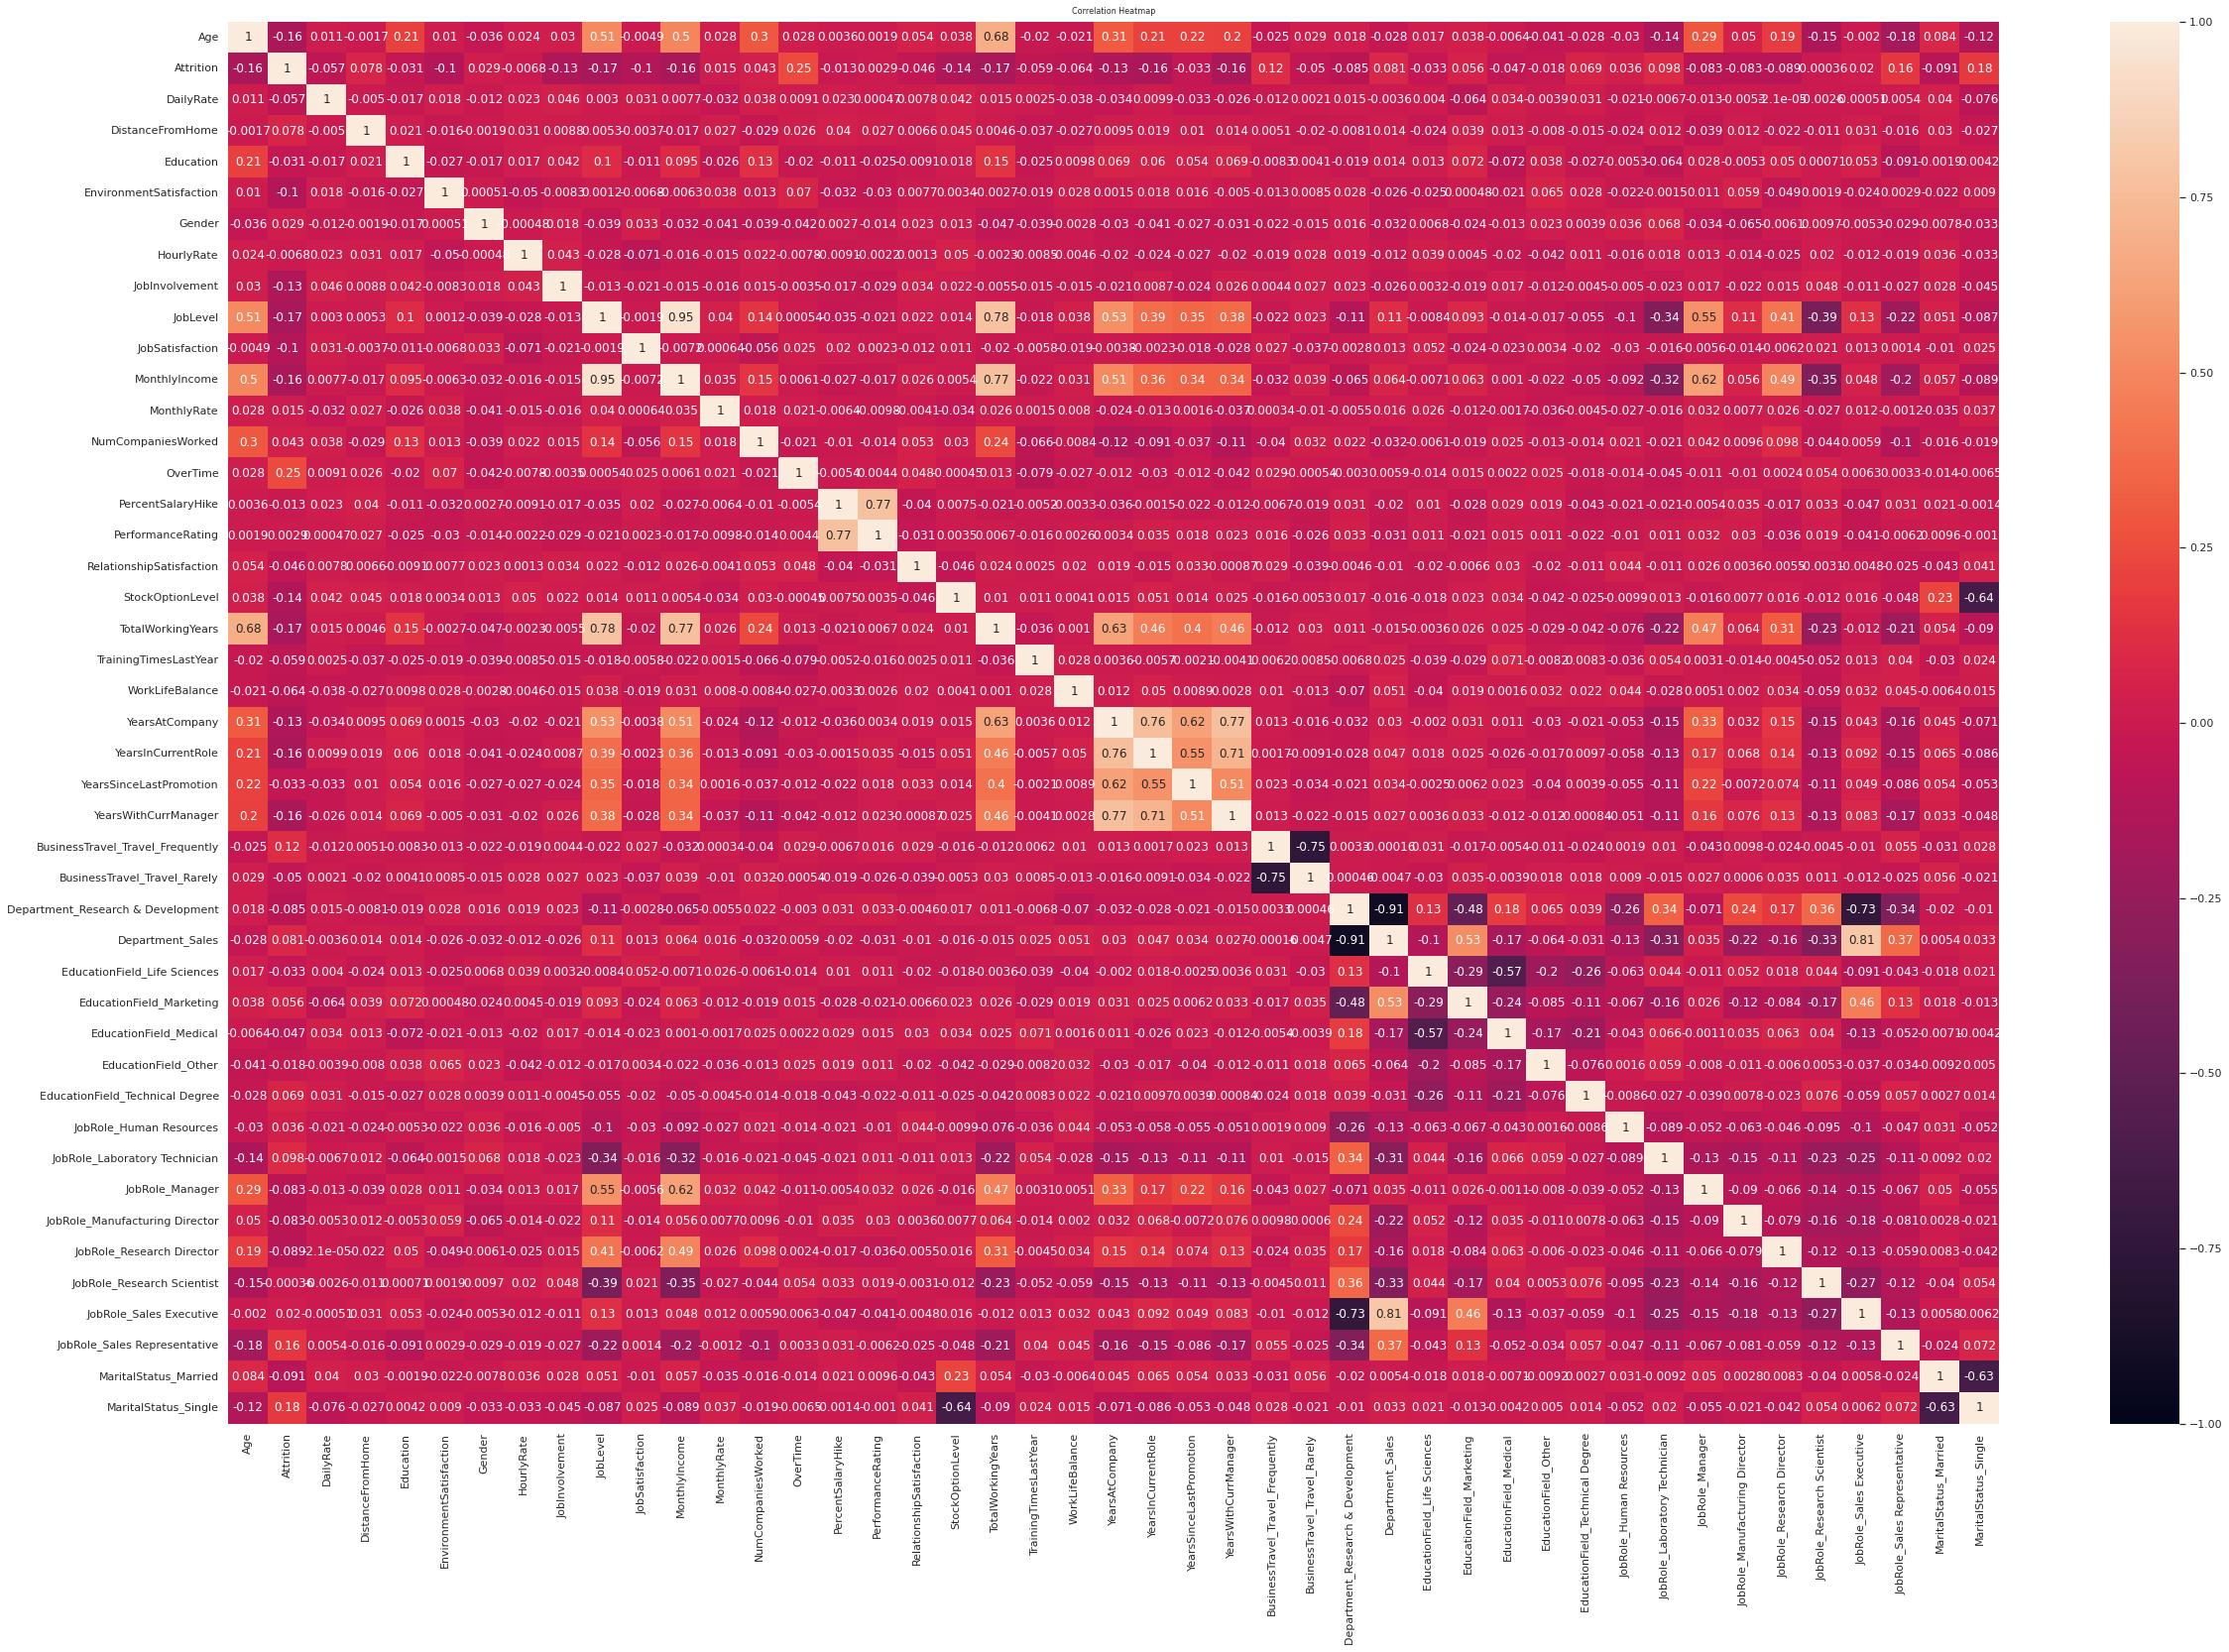

In [ ]:
# correlation matrix
plt.figure(figsize=(40, 26))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=8);

##### Key-findings: 
1. The target variable 'Attrition' seems to be more correlated with DistanceFromHome, OverTime, BusinessTravel_Frequently as well as MartialStatus_Single. 
2. Attrition is negatively correlated with MonthlyIncome. 
3. Also other independent features correlate e.g. JobRole_Manager and MonthlyIncome or JobSatisfaction negatively with HourlyRate.

In order to make the correlation with the target variable more readable, let's generate a pandas dataframe entailing for each feature the correlation coefficient by using pearsons rho and it's corresponding p-value. The latter helps to identify whether the correlation is statistcally significant.

In [ ]:
# correlation dataframe with the target 

corr_dict = {}

for col in df.columns:
  if col != 'Attrition':
      r, p = scipy.stats.pearsonr(df[col], df['Attrition'])
      sign = '+' if np.sign(r) == 1.0 else '-'
      r = np.abs(r)
      corr_dict[col] = [sign, r,  np.format_float_positional(p)]
  else:
    pass

corr_df = pd.DataFrame(corr_dict).transpose()
corr_df.columns=["sign", "pearsonr", "p-value"]
corr_df.sort_values("pearsonr", ascending=False)

,sign,pearsonr,p-value
OverTime,+,0.246118,0.000000000000000000001009254033656135
MaritalStatus_Single,+,0.175419,0.000000000012657022689959532
TotalWorkingYears,-,0.171063,0.00000000004061878111266784
JobLevel,-,0.169105,0.00000000006795384780015471
YearsInCurrentRole,-,0.160545,0.0000000006003185843641575
MonthlyIncome,-,0.15984,0.0000000007147363985353496
Age,-,0.159205,0.0000000008356308021103691
JobRole_Sales Representative,+,0.157234,0.0000000013522573647631252
YearsWithCurrManager,-,0.156199,0.0000000017369867845240066
StockOptionLevel,-,0.137145,0.0000001301014966001892


#### 1.3 Feature Engineering
Feature Engineering refers to the derivation of new features, based on exisitng columns, in the hope, they help the ml model to make better predictions. EDA or domain knowledge helps to create new and valuable features. Meanwhile there are techniques and libraries for automated feature engineering. For illustration purposes, let's create one new feature. As we have seen, employees with overtime and martial status = single tend to quit their job. How's about employees, that are both single and have overtime?

In [ ]:
# create a variable for single and overtime and see, whether there is a stronger correlation

df['Single_and_Overtime'] = df.apply(lambda x: 1 if x['OverTime']== 1 and x['MaritalStatus_Single']== 1 else 0, axis=1)
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Single_and_Overtime
0,0.446350,1,0.742527,-1.010909,-0.891688,-0.660531,0,1.383138,0.379672,-0.057788,1.153254,-0.108350,0.726020,2.125136,1,-1.150554,-0.426230,-1.584178,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
1,1.322365,0,-1.297775,-0.147150,-1.868426,0.254625,1,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,1.488876,-0.678049,0,2.129306,2.346151,1.191438,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0.008343,1,1.414363,-0.887515,-0.891688,1.169781,1,1.284725,-1.026167,-0.961486,0.246200,-0.937654,-1.674841,1.324226,1,-0.057267,-0.426230,-0.658973,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1
3,-0.429664,0,1.461466,-0.764121,1.061787,1.169781,0,-0.486709,0.379672,-0.961486,0.246200,-0.763634,1.243211,-0.678049,1,-1.150554,-0.426230,0.266233,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,-1.086676,0,-0.524295,-0.887515,-1.868426,-1.575686,1,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,0.325900,2.525591,0,-0.877232,-0.426230,1.191438,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
r, p = scipy.stats.pearsonr(df['Single_and_Overtime'], df['Attrition'])
print(r, p)

0.28490381603670123 7.500163983854884e-29


In [ ]:
pd.crosstab(index=df['Attrition'], columns=df['Single_and_Overtime']).apply(lambda c: c/c.sum())

Single_and_Overtime,0,1
Attrition,,
0,0.871546,0.503817
1,0.128454,0.496183


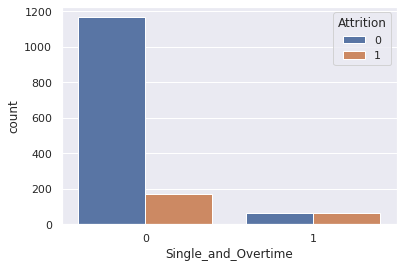

In [ ]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Single_and_Overtime", hue="Attrition");


Key-findings:
1.  The newly created variable has the highest correlation. 
2. If the employee is single and has overtime, the churn probability increases from 13% to 50% in comparison to not single and not overtime.



In [ ]:
pd.crosstab(index=df['Attrition'], columns=df['Gender']).apply(lambda c: c/c.sum())

Gender,0,1
Attrition,,
0,0.852041,0.829932
1,0.147959,0.170068


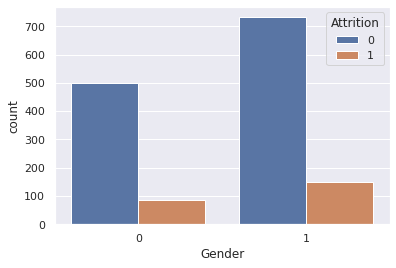

In [ ]:
fig = plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Gender", hue="Attrition");

#### 1.4 Data Visualization
Last but not least, data visualization deepens the data understanding but also allows to test different business hypothesis or find first insights. E.g. let's figure out the monthly payment per JobRole or does job quitter tend to have a higher distance from home. 

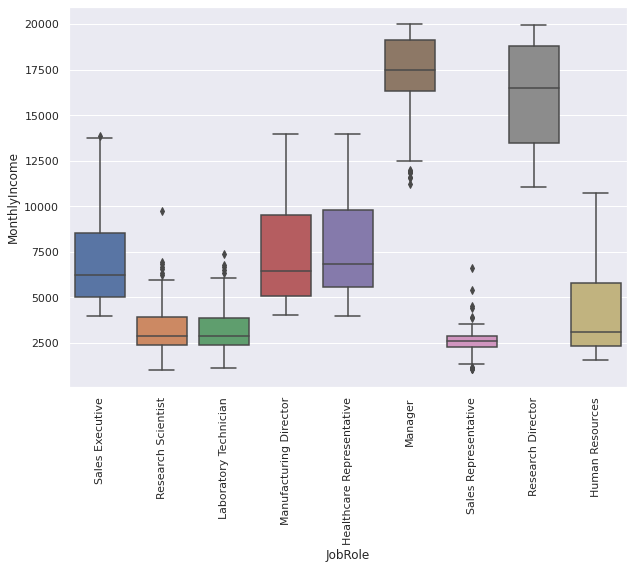

In [ ]:
ax = sns.boxplot(data=data_raw, x="JobRole", y="MonthlyIncome", orient='v')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

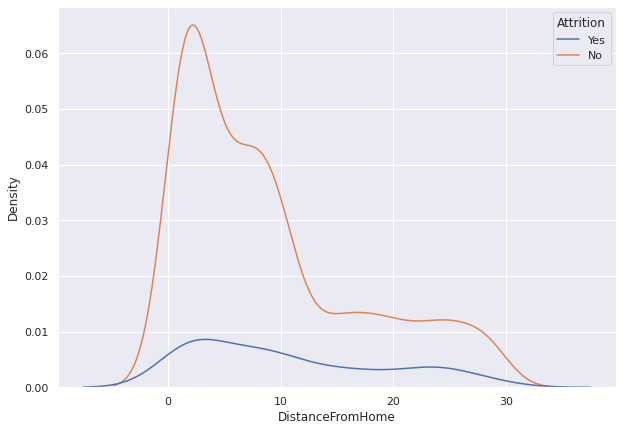

In [ ]:
# lets plot a simple densityplot in order to see whether left employees had a longer distance to work  
sns.kdeplot(data=data_raw, x="DistanceFromHome", hue="Attrition");

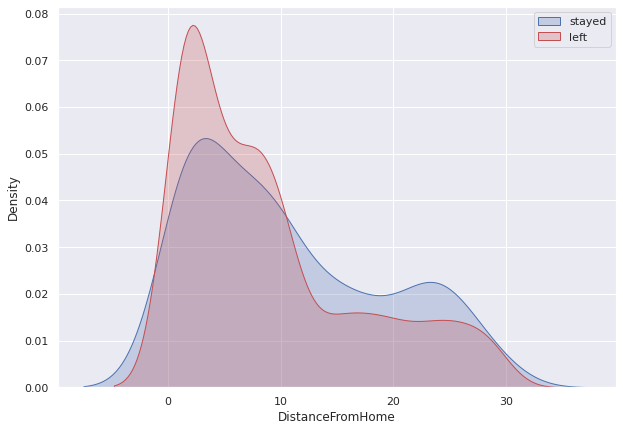

In [ ]:
# The above graph shows that stayed employees had a shorter distance to work
# however plotting two individual density plot might show the relationship better 

feature = "DistanceFromHome"

p1=sns.kdeplot(data_raw[data_raw['Attrition']=='Yes'][feature], shade=True, color="b",Label="stayed")
p1=sns.kdeplot(data_raw[data_raw['Attrition']=='No'][feature], shade=True, color="r",Label="left")
plt.legend(loc="upper right");
#

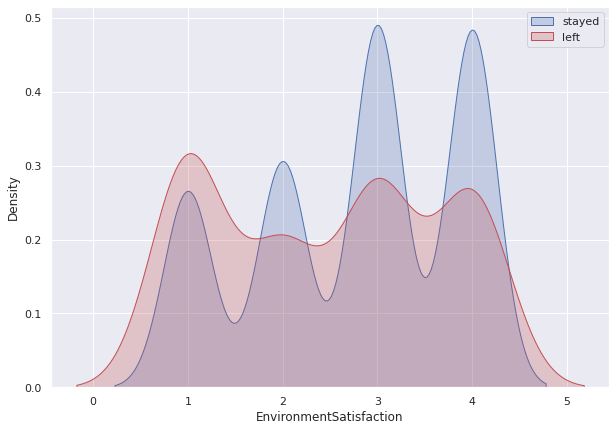

In [ ]:
feature = "EnvironmentSatisfaction"

p1=sns.kdeplot(data_raw[data_raw['Attrition']=='No'][feature], shade=True, color="b",Label="stayed")
p1=sns.kdeplot(data_raw[data_raw['Attrition']=='Yes'][feature], shade=True, color="r",Label="left")
plt.legend(loc="upper right");
#

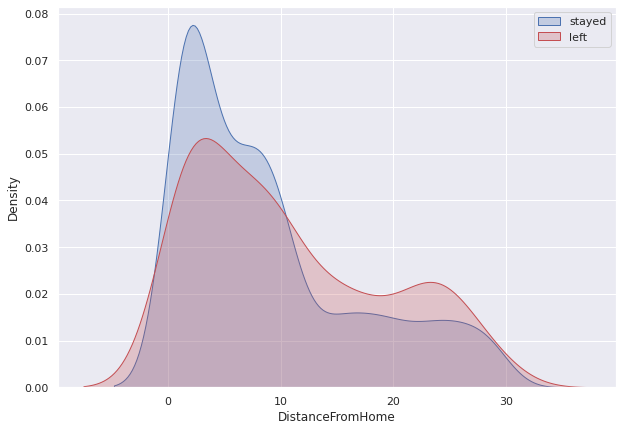

In [ ]:
feature = "DistanceFromHome"

p1=sns.kdeplot(data_raw[data_raw['Attrition']=='No'][feature], shade=True, color="b",Label="stayed")
p1=sns.kdeplot(data_raw[data_raw['Attrition']=='Yes'][feature], shade=True, color="r",Label="left")
plt.legend(loc="upper right");

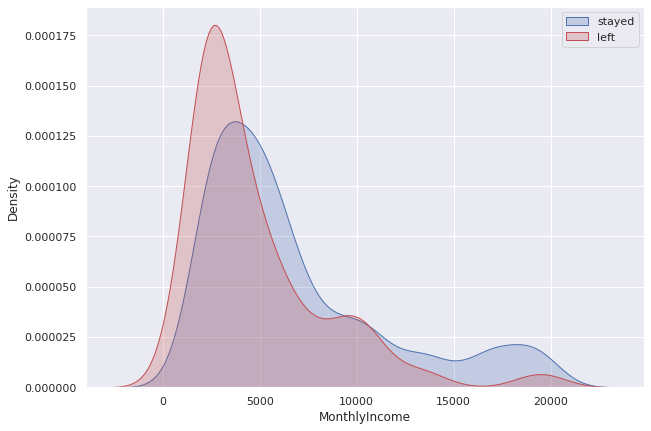

In [ ]:
feature = "MonthlyIncome"

p1=sns.kdeplot(data_raw[data_raw['Attrition']=='No'][feature], shade=True, color="b",Label="stayed")
p1=sns.kdeplot(data_raw[data_raw['Attrition']=='Yes'][feature], shade=True, color="r",Label="left")
plt.legend(loc="upper right");

In [ ]:
# corr_df = df.corr()
# corr_df['Attrition'].sort_values(ascending=False)

# 3. Outlier Detection
We know that outliers potentially lead to poor performance of machine learning models. However, not every algorithm is sensitive to outliers. Here is a list of ml algorithms which are sensitive to outliers:


> Linear Regression,
Logistic Regression,
Support Vector Machine,
K- Nearest Neighbors,
K-Means Clustering,
Hierarchical Clustering,
Principal Component Analysis

List of Machine Learning algorithms which are not sensitive to outliers:

> Decision Tree,
Random Forest,
XGBoost,
AdaBoost, Naive Bayes

Types of Outliers:
1. Global outlier, single data point with respect to one feature (univariate)
2. Contextual (Conditional) Outliers with respect to other features (multivariate)
3. Collective (group of outliers)

Concept to deal with outliers:

1. Deleting observations
2. Transforming values
3. Imputation

Concept to find and remove with outliers:
>Z-Score,
IQR,
Isolation Forest,
Rule-based,
Density-based,
Embedding-based (PCA, Autoencoders)

Since the dataframe has lot's of features, a holistic outlier detection for each feature or combination of features requieres lots of work, we will compare the success of the isolation forest and Z-Score value to two numerical features. Spoiler alert: not every technique is successfull to the respectiv task, which is a daily challenge to every data analyst. 

#### 3.1. Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

# Split the dataset into X and y
df_anomaly = df.copy()
X = df_anomaly.loc[:, df_anomaly.columns != 'Attrition']
y = df_anomaly.loc[:, df_anomaly.columns == 'Attrition']

clf = IsolationForest(random_state=0).fit(X)
df_anomaly["Anomaly"] = clf.predict(X)

df_anomaly.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Single_and_Overtime,Anomaly
0,0.446350,1,0.742527,-1.010909,-0.891688,-0.660531,0,1.383138,0.379672,-0.057788,1.153254,-0.108350,0.726020,2.125136,1,-1.150554,-0.426230,-1.584178,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,-1
1,1.322365,0,-1.297775,-0.147150,-1.868426,0.254625,1,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,1.488876,-0.678049,0,2.129306,2.346151,1.191438,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,-1
2,0.008343,1,1.414363,-0.887515,-0.891688,1.169781,1,1.284725,-1.026167,-0.961486,0.246200,-0.937654,-1.674841,1.324226,1,-0.057267,-0.426230,-0.658973,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,-1
3,-0.429664,0,1.461466,-0.764121,1.061787,1.169781,0,-0.486709,0.379672,-0.961486,0.246200,-0.763634,1.243211,-0.678049,1,-1.150554,-0.426230,0.266233,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
4,-1.086676,0,-0.524295,-0.887515,-1.868426,-1.575686,1,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,0.325900,2.525591,0,-0.877232,-0.426230,1.191438,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1


In [ ]:
df_anomaly.Anomaly.value_counts()

 1    990
-1    480
Name: Anomaly, dtype: int64

#### Key Findings:

1. The isolation Forest detected 480 outlier, which is a lot and hence seems to be suspicious. Maybe one has to test different hyperparameters or stick to another outlier detection technique. 
2. It is unclear why the datapoint is an outlier in terms of which feature. 

In order to minimize the number of outliers, there is a parameter contamination which means how many datapoints do we want to detect as outlier. I assume it focuses on the % which are the most outliers. This eases the analysis, why these outlier are outliers. 

In [ ]:
contamination_in_percent = 0.05

clf = IsolationForest(random_state=0, contamination=contamination_in_percent).fit(X)
df_anomaly["Anomaly"] = clf.predict(X)

df_anomaly.Anomaly.value_counts()

 1    1396
-1      74
Name: Anomaly, dtype: int64

Key Findings:
1. Isolation Forest is easy to apply, since you don't need detect outliers based on individual features. However that is exactly the tradeoff, it is not easy to detect based on which feature is a datapoint detected as an outlier. 
2. With a smaller amount of outliers, it is potentially easier to detect why these datapoints are outliers (in terms of based on which feaures) and hence on which variables to focus for further outliers analysis. However this is just the case when a datapoint is a local outlier, a conditional outlier is even more complex. Consequently on has either to put more effort in figuring out the reasons or one has to blindly trust the blackbox Isolation Forest.



Let's apply Z-Score outlier detection technique to the two numeric features DistanceFromHome and MonthlyIncome.

In [ ]:
df_anomaly["Z_Score_MonthlyIncome"] = stats.zscore(df_anomaly["MonthlyIncome"], ddof=0)
df_anomaly["Z_Score_DistFromHome"] = stats.zscore(df_anomaly["DistanceFromHome"], ddof=0)
df_anomaly.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Single_and_Overtime,Anomaly,Z_Score_MonthlyIncome,Z_Score_DistFromHome
0,0.446350,1,0.742527,-1.010909,-0.891688,-0.660531,0,1.383138,0.379672,-0.057788,1.153254,-0.108350,0.726020,2.125136,1,-1.150554,-0.426230,-1.584178,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,-1,-0.108350,-1.010909
1,1.322365,0,-1.297775,-0.147150,-1.868426,0.254625,1,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,1.488876,-0.678049,0,2.129306,2.346151,1.191438,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,-1,-0.291719,-0.147150
2,0.008343,1,1.414363,-0.887515,-0.891688,1.169781,1,1.284725,-1.026167,-0.961486,0.246200,-0.937654,-1.674841,1.324226,1,-0.057267,-0.426230,-0.658973,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,-1,-0.937654,-0.887515
3,-0.429664,0,1.461466,-0.764121,1.061787,1.169781,0,-0.486709,0.379672,-0.961486,0.246200,-0.763634,1.243211,-0.678049,1,-1.150554,-0.426230,0.266233,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,-0.763634,-0.764121
4,-1.086676,0,-0.524295,-0.887515,-1.868426,-1.575686,1,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,0.325900,2.525591,0,-0.877232,-0.426230,1.191438,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,-0.644858,-0.887515


In [ ]:
df_anomaly["Z_Score_MonthlyIncome"].max(), df_anomaly["Z_Score_DistFromHome"].max()

(2.867626482666987, 2.4441291486822943)

Key Findings:
1. With Z-Score, usually one would apply a rule for handling outliers, e.g. delete all datapoints whose Z-score is greater than 3. In our case the max Z-score of the two variabls are less than 3, hence we don't do anything. The creators of this artificial dataset probably encounterd this rule dring the generation process.

# 3: Class balancing using SMOTE

Class imbalance can have severe negative effects on the performance of a ml model. E.g. if the training dataset contains 90% positives and 10% negatives, a ml model which only predicts positives has already an accuracy of 90%. Ideally an ml model for binary classification has a class distribution of 50% along with lots of datapoints per class. If this is not the case, one has to handle the class imbalance. Many techniques can be applied e.g. undersampling of the majority class, however in this case we will apply SMOTE (Synthetic Minority Over-sampling Technique). The algorithm aims to balance the class distribution by generating synthetic samples of the minority class with the following steps:
1. Calculate the Distance Between Samples: For each sample in the minority class, SMOTE calculates the distance between it and its k nearest neighbors. The value of k is a user-defined parameter.
2. Generate Synthetic Samples: For each sample in the minority class, SMOTE generates a synthetic sample by selecting one of its k nearest neighbors at random and computing a new sample at a random point between the selected sample and the current sample. This process is repeated until the desired number of synthetic samples is generated.
3. Combine the Synthetic Samples with the Original Minority Samples.

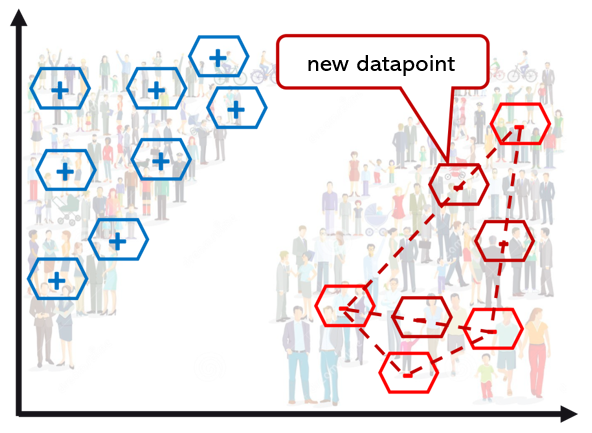

In [ ]:
# Smote will be be applied to the training dataset, let's train test split the entire dataframe 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape)

(1176, 45) (294, 45)


In [ ]:
# the epmloyees that churned are highly underreprecented
y_train.value_counts()

Attrition
0            980
1            196
dtype: int64

In [ ]:
# Apply SMOTE only to the training dataset
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)

y_sm.value_counts()

Attrition
0            980
1            980
dtype: int64

After applying SMOTE the class distribution is balanced

In [ ]:
# lets concat x and y after smote together
smote_df = pd.concat([X_sm, y_sm], axis = 1)
smote_df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Single_and_Overtime,Attrition
0,0.117845,1.300325,-0.887515,-0.891688,1.169781,1,-1.323220,-1.026167,-0.057788,1.153254,-0.266434,0.754550,0.122861,0,0.762698,-0.42623,1.191438,0.241988,0.221185,-2.171982,0.338096,0.161947,0.764998,1.493867,0.245834,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,-0.429664,-0.712706,-1.010909,-0.891688,-1.575686,0,1.579964,0.379672,0.845911,1.153254,1.477804,0.117056,-0.678049,1,-0.877232,-0.42623,0.266233,-0.932014,0.478316,-1.396086,0.338096,1.304909,2.697683,1.804297,2.208310,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
2,-0.648668,-1.488665,-0.147150,0.085049,-1.575686,0,-1.569253,-1.026167,-0.961486,-0.660853,-1.113798,1.117145,-0.678049,0,-0.877232,-0.42623,0.266233,-0.932014,-1.321601,0.155707,1.754054,-0.981014,-1.167687,-0.679146,-1.155935,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
3,-1.415181,0.449992,0.963398,-0.891688,1.169781,0,1.530758,0.379672,-0.961486,-0.660853,-0.912156,-1.537673,-0.678049,0,-0.603911,-0.42623,-1.584178,0.241988,-1.321601,0.155707,-2.493820,-0.981014,-1.167687,-0.679146,-1.155935,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
4,-1.196177,0.903668,-0.517332,0.085049,1.169781,0,-1.766079,-1.026167,-0.961486,0.246200,-0.751522,0.992907,-1.078504,0,0.762698,-0.42623,1.191438,-0.932014,-0.807339,-0.620189,0.338096,-0.491174,-0.615492,-0.679146,-1.155935,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0


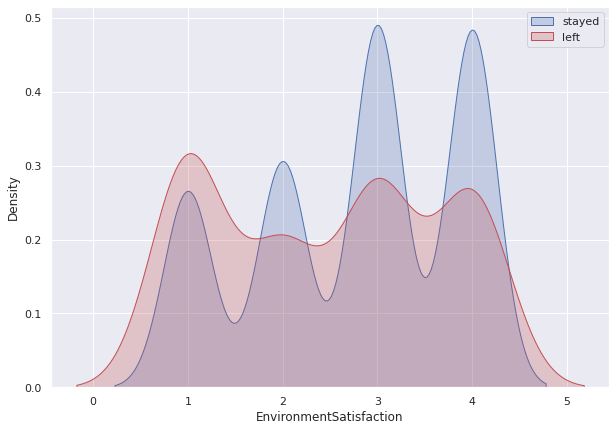

In [ ]:
feature = "EnvironmentSatisfaction"

p1=sns.kdeplot(data_raw[data_raw['Attrition']=='No'][feature], shade=True, color="b",Label="stayed")
p1=sns.kdeplot(data_raw[data_raw['Attrition']=='Yes'][feature], shade=True, color="r",Label="left")
plt.legend(loc="upper right");

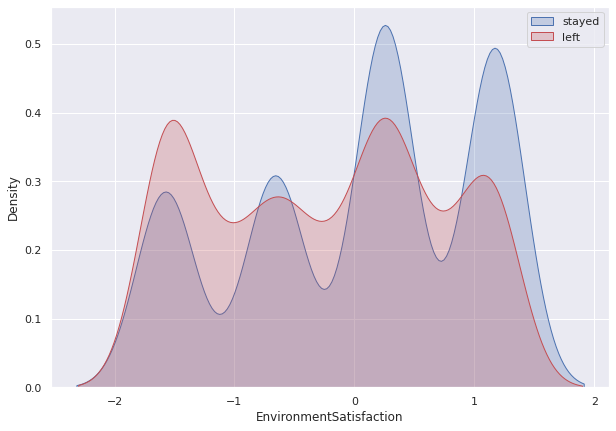

In [ ]:
# compare the distribution before and after smote 
feature = "EnvironmentSatisfaction"

p1=sns.kdeplot(smote_df[smote_df['Attrition']==0][feature], shade=True, color="b",Label="stayed")
p1=sns.kdeplot(smote_df[smote_df['Attrition']==1][feature], shade=True, color="r",Label="left")
plt.legend(loc="upper right");

In [ ]:
# Let's compare the correlation before and after smote 
corr_dict = {}

for col in smote_df.columns:
  if col != 'Attrition':
      r, p = scipy.stats.pearsonr(smote_df[col], smote_df['Attrition'])
      sign = '+' if np.sign(r) == 1.0 else '-'
      r = np.abs(r)
      corr_dict[col] = [sign, r,  np.format_float_positional(p)]
  else:
    pass

corr_df = pd.DataFrame(corr_dict).transpose()
corr_df.columns=["sign", "pearsonr", "p-value"]
corr_df.sort_values("pearsonr", ascending=False)

,sign,pearsonr,p-value
MaritalStatus_Married,-,0.28337,0.00000000000000000000000000000000000016274350...
TotalWorkingYears,-,0.27161,0.00000000000000000000000000000000017227312621...
JobLevel,-,0.263075,0.00000000000000000000000000000002185361879970...
YearsInCurrentRole,-,0.258883,0.0000000000000000000000000000002211413683136584
MonthlyIncome,-,0.256272,0.0000000000000000000000000000009153125739551223
Age,-,0.2544,0.0000000000000000000000000000025084245707634834
YearsWithCurrManager,-,0.239372,0.000000000000000000000000006101916601652412
BusinessTravel_Travel_Rarely,-,0.233124,0.00000000000000000000000013370501797308916
StockOptionLevel,-,0.22024,0.00000000000000000000005867477431593134
EducationField_Life Sciences,-,0.216126,0.00000000000000000000037836846661456127


Key findings:
1. Now most of the features with stronger correlation have a negative sign, which makes sense, because we are oversampling datapoints that didn't quit their job.

# 4: Machine Learning
##### Getting a good ml model, potentially requieres the following steps:
##### 1. Train different models and compare their performance
##### 2. Select the best models and optimize hyperparameters

In [ ]:
# sklearn modules for preprocessing

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Common sklearn Model Helpers
from sklearn import feature_selection, model_selection

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, log_loss, f1_score, accuracy_score, make_scorer, average_precision_score

import warnings
warnings.filterwarnings('ignore')

#### 4.1 Model Training and performance comparison
In order to achieve this, we first build a modelfactory and the use k-fold cross validation in order to measure the performance across different training sets. We the aggregate the resulat per model and training set in a simple table/graph. We will use both the original and the smote dataset in order to see whether smote provides a substantial positive impact on training performance.

In [ ]:
# selection of algorithms to consider and set performance measure
models_factory = []
models_factory.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state=7, class_weight='balanced')))
models_factory.append(('Random Forest', RandomForestClassifier( n_estimators=100, random_state=7)))
models_factory.append(('SVM', SVC(gamma='auto', random_state=7)))
models_factory.append(('KNN', KNeighborsClassifier()))
models_factory.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=7)))
models_factory.append(('Gaussian NB', GaussianNB()))
models_factory.append(('XGBoost', GradientBoostingClassifier()))
models_factory.append(('AdaBoost', AdaBoostClassifier()))
models_factory.append(('NN', MLPClassifier()))

In [ ]:
# Let's quickly concat the dataet which later be used
test_df = pd.concat([X_test, y_test], axis = 1)
smote_df = pd.concat([X_sm, y_sm], axis = 1)
final_smote_df = pd.concat([smote_df, test_df], axis = 0)


In [ ]:
# plot the performance for the normal training data 

acc_results = []
auc_results = []
f1_results = []

names = []

# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD', 
       'F1 Mean', 'F1 STD']

df_results = pd.DataFrame(columns=col)
i = 0

for name, model in models_factory:
    kfold = model_selection.KFold(n_splits=5)  # 10-fold cross-validation

    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

    cv_f1_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    f1_results.append(cv_f1_results)
    
    names.append(name)

    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2),
                         round(cv_f1_results.mean()*100, 2),
                         round(cv_f1_results.std()*100, 2)
                         ]
    i += 1
df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD,F1 Mean,F1 STD
2,SVM,83.74,4.52,85.55,2.17,27.22,5.65
0,Logistic Regression,82.40,2.27,75.42,1.38,49.16,5.26
6,XGBoost,80.12,1.53,86.82,2.12,46.17,4.43
8,NN,80.09,2.43,85.63,2.03,48.63,6.79
1,Random Forest,79.81,4.57,85.38,2.11,29.18,8.14
7,AdaBoost,79.40,4.53,85.97,3.07,50.49,4.05
5,Gaussian NB,76.55,3.99,74.32,2.99,46.71,7.00
3,KNN,67.68,6.94,83.76,1.71,20.39,3.79
4,Decision Tree Classifier,60.43,2.32,77.98,2.06,33.77,5.90


In [ ]:
# plot the performance for the normal training data 

acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=col)
i = 0
# evaluate each model using cross-validation
for name, model in models_factory:
    kfold = model_selection.KFold(n_splits=10)  # 10-fold cross-validation

    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
2,SVM,83.39,6.18,85.64,2.62
0,Logistic Regression,82.32,3.98,76.02,2.83
7,AdaBoost,80.71,4.84,85.80,2.42
6,XGBoost,80.54,4.11,86.91,2.72
8,NN,80.26,5.39,85.12,1.55
1,Random Forest,80.16,4.72,85.21,2.48
5,Gaussian NB,77.12,6.81,74.58,5.08
3,KNN,66.96,6.57,84.36,2.42
4,Decision Tree Classifier,61.22,4.77,77.05,4.65


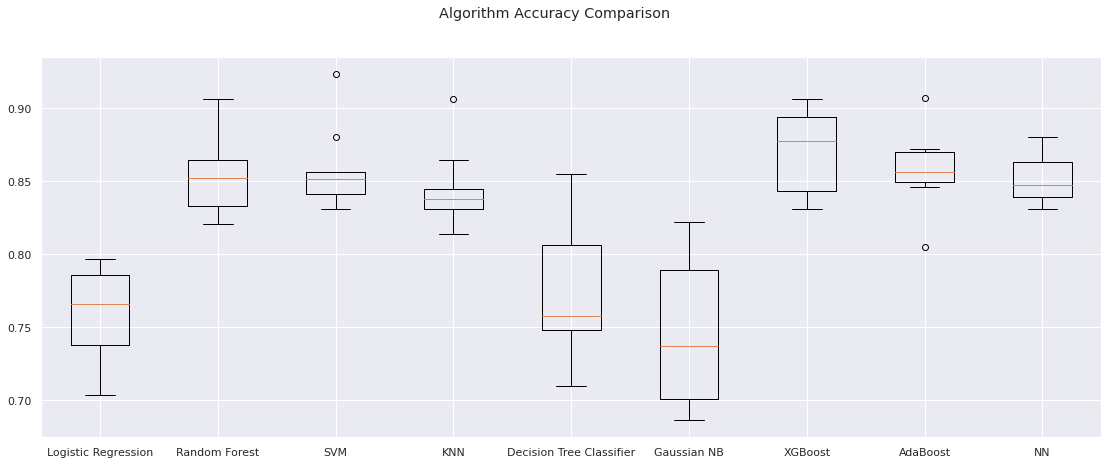

In [ ]:
fig = plt.figure(figsize=(19, 7))
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()

Let's apply the same to our SMOTE enhanced dataset

In [ ]:
# Train-Test-Split the smote dataset
X_smote = final_smote_df.loc[:, final_smote_df.columns != 'Attrition']
y_smote = final_smote_df.loc[:, final_smote_df.columns == 'Attrition']
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2)

print(X_train.shape, X_test.shape)

(1803, 45) (451, 45)


In [ ]:
# plot the performance for the normal training data 

acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
df_results = pd.DataFrame(columns=col)
i = 0
# evaluate each model using cross-validation
for name, model in models_factory:
    kfold = model_selection.KFold(
        n_splits=10)  # 10-fold cross-validation

    cv_acc_results = model_selection.cross_val_score(  # accuracy scoring
        model, X_train, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(  # roc_auc scoring
        model, X_train, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1
df_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
1,Random Forest,97.59,0.78,92.07,2.51
8,NN,96.10,1.27,89.96,1.56
6,XGBoost,96.05,0.99,91.18,1.58
2,SVM,95.02,1.48,89.02,2.24
7,AdaBoost,94.48,1.40,88.46,1.80
3,KNN,93.41,1.43,79.92,2.50
0,Logistic Regression,93.27,1.72,87.08,2.87
4,Decision Tree Classifier,83.49,3.49,83.36,3.44
5,Gaussian NB,81.97,3.28,65.66,3.88


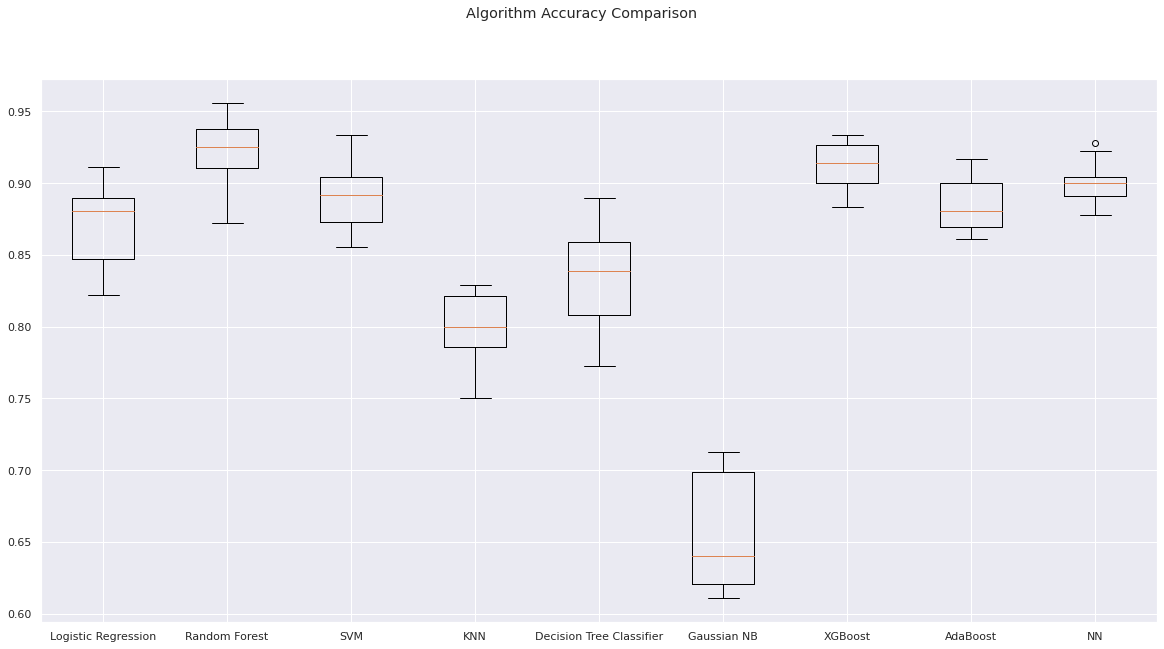

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()

## 5. Hyperparameter-Optimization using GridSearch
Now we will simply set a set of different hyperparameters, iterating over each combination. For the sake of time usage, we will only have 2 parameters and 2 values each, but feel free to try more.

In [ ]:
# GridSearch for identifying optimal hyperparameters

"""param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }"""

param_grid = {
        'min_child_weight': [5, 10],
        'max_depth': [4, 5]
        }

log_gs = GridSearchCV(XGBClassifier(objective= 'binary:logistic', # setting GridSearchCV
                                          nthread=4, 
                                         seed=42),                     
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

log_grid = log_gs.fit(X_train, y_train)
log_opt = log_grid.best_estimator_
results = log_gs.cv_results_

print('='*20)
print("best params: " + str(log_gs.best_estimator_))
print("best params: " + str(log_gs.best_params_))
print('best score:', log_gs.best_score_)
print('='*20)

best params: XGBClassifier(max_depth=4, min_child_weight=10, nthread=4, seed=42)
best params: {'max_depth': 4, 'min_child_weight': 10}
best score: 0.9674936693500745


Meanwhile more advanced techniques for hyperparameter optimization exist, e.g. with a bayesian approach. This will be covered in a seperate tutorial. 

#### Final ml model evaluation
The following metrices are covered:
1. Confusion Matrix
2. Accuracy
3. True positives, False Positives, True Negatives, False Negatives
4. F1-Score
5. Area Under the Curve

In [ ]:
# Train-Test-Split the smote dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

X_smote = final_smote_df.loc[:, final_smote_df.columns != 'Attrition']
y_smote = final_smote_df.loc[:, final_smote_df.columns == 'Attrition']

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2)

print(X_train.shape, X_test.shape)

(1803, 45) (451, 45)


In [ ]:
# due to randomness the class is slightly imbalanced in the training set
y_train.Attrition.value_counts()

0    999
1    804
Name: Attrition, dtype: int64

In [ ]:
# fit model no training data
clf = XGBClassifier(max_depth=4, min_child_weight=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Confusion Matrix

In [ ]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['True_P', 'True_N'], index = ['Pred_P', 'Pred_N'])

,True_P,True_N
Pred_P,226,8
Pred_N,24,193


In [ ]:
pd.DataFrame(confusion_matrix(y_test, y_pred, normalize = 'all'), columns = ['True_P', 'True_N'], index = ['Pred_P', 'Pred_N'])

,True_P,True_N
Pred_P,0.501109,0.017738
Pred_N,0.053215,0.427938


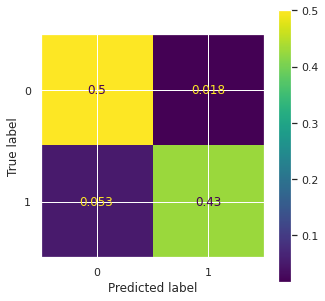

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize = 'all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()
plt.show()

In [ ]:
from sklearn import metrics

tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize = 'all').ravel() # or sum(confusion_matrix(y_test, y_pred).ravel())
acc = accuracy_score(y_test, y_pred)
f1=f1_score(y_test, y_pred, average='binary')
auc = metrics.roc_auc_score(y_test, y_pred)

metrics_df = pd.DataFrame.from_dict({
    'acc': accuracy_score(y_test, y_pred), 
    'tp': tp,
    'tn': tn,
    'fp': fp,
    'fn': fn,
    'f1': f1,
    'auc':auc
}, columns = ['XGBoost'], orient='index')

In [ ]:
metrics_df

,cool
acc,0.929047
tp,0.427938
tn,0.501109
fp,0.017738
fn,0.053215
f1,0.923445
auc,0.927606


Lastly, let's predict the churn probability for every employee in the dataset, compare how good the model can predict, where most of the errors occure and which further analytical questions can be answered.


In [ ]:
# now we are predicting each employee from the original dataframe and see what the ten employees with the higheghst churn rates are

df_with_pred = X.copy()

pred_class = clf.predict(df_with_pred)
pred_proba = clf.predict_proba(df_with_pred)[:, 1]

df_with_pred['pred_class'] = pred_class
df_with_pred['pred_proba'] = pred_proba

df_with_pred = pd.concat([df_with_pred, y], axis =1)
df_with_pred.sort_values("pred_proba", ascending=False).head(10)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Single_and_Overtime,pred_class,pred_proba,Attrition
463,-1.196177,-0.821787,1.827158,0.085049,0.254625,1,0.005356,-2.432006,-0.961486,1.153254,-0.884534,1.250800,-0.678049,1,0.762698,-0.426230,-0.658973,-0.932014,-1.321601,0.155707,-2.493820,-0.981014,-1.167687,-0.679146,-1.155935,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,0.969510,1
892,-1.962690,-0.739977,0.099639,0.085049,-1.575686,0,1.481551,-1.026167,-0.961486,-0.660853,-0.986736,-1.147531,-0.678049,1,2.675949,2.346151,-0.658973,-0.932014,-1.321601,-0.620189,1.754054,-0.981014,-0.891589,-0.679146,-1.155935,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0.964731,1
1060,-1.415181,-1.044906,-0.023755,0.085049,-0.660531,1,1.137106,0.379672,-0.961486,-1.567907,-0.707752,0.377338,-0.277594,1,-1.150554,-0.426230,0.266233,-0.932014,-0.935905,-0.620189,-1.077862,-1.144294,-1.167687,-0.679146,-1.155935,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0.961567,1
1313,-0.867672,-1.121758,0.469821,0.085049,-1.575686,1,-0.486709,-1.026167,-0.961486,-1.567907,-0.885596,-1.567889,0.523316,1,-0.057267,-0.426230,1.191438,2.589994,-0.935905,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-1.155935,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.954892,1
731,-1.853188,0.730131,0.223033,0.085049,1.169781,0,1.579964,-1.026167,-0.961486,-1.567907,-0.829290,0.556809,-0.678049,1,-0.057267,-0.426230,-1.584178,-0.932014,-1.321601,-0.620189,0.338096,-0.981014,-1.167687,-0.679146,-1.155935,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0.949952,1
127,-1.962690,-0.680478,1.580370,-1.868426,1.169781,1,-0.781948,0.379672,-0.961486,0.246200,-1.025832,1.757731,-0.678049,1,1.036019,-0.426230,1.191438,-0.932014,-1.450167,-0.620189,-1.077862,-1.144294,-1.167687,-0.679146,-1.155935,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0.941399,1
1339,-1.634185,-1.020115,-0.270544,-1.868426,1.169781,1,0.448214,0.379672,-0.961486,-0.660853,-0.856487,1.655417,-0.678049,1,2.129306,2.346151,-1.584178,-0.932014,-1.321601,-0.620189,0.338096,-0.981014,-1.167687,-0.679146,-1.155935,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0.940123,1
656,-0.539166,-1.062260,1.950552,1.061787,-1.575686,1,1.038693,0.379672,-0.961486,1.153254,-0.787856,0.520409,-0.678049,1,2.402628,2.346151,0.266233,-0.932014,-1.321601,-0.620189,-2.493820,-0.981014,-1.167687,-0.679146,-0.875581,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0.940063,1
911,-1.305679,-0.504462,1.827158,-1.868426,0.254625,1,0.349801,-2.432006,-0.961486,1.153254,-1.144183,-0.881628,-0.678049,1,-0.330589,-0.426230,1.191438,-0.932014,-1.321601,0.931603,0.338096,-0.981014,-1.167687,-0.368715,-1.155935,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0.939833,1
1255,-0.429664,-1.466354,0.840004,0.085049,-1.575686,0,0.399008,0.379672,0.845911,-1.567907,0.437933,-0.593238,-0.277594,1,1.309341,2.346151,0.266233,-0.932014,-0.035946,-0.620189,-1.077862,-1.144294,-1.167687,-0.679146,-1.155935,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0.939587,1


8/10 employees that have the highest churnrate are both single and overtime. 

In [ ]:
df_with_pred.pred_class.value_counts()

0    1283
1     989
Name: pred_class, dtype: int64

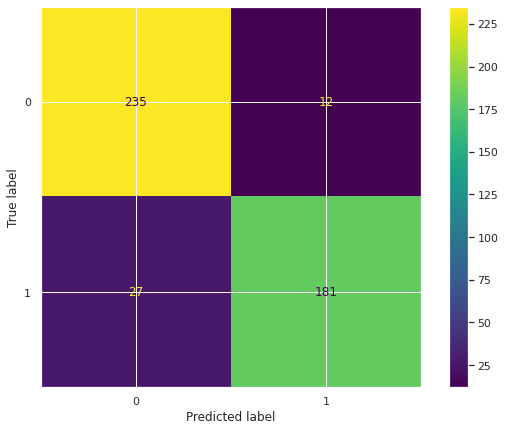

In [ ]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()


With the following information, one could further analyse questions e.g.:
1. What do the employees with the highest churn probability have in common?
2. What do the falsely negative (FP) employees have in common?

# 5 Explainable & Trustworthy AI using SHAP
### XAI methods provide minimum the following three business values:
#### 1. Global Explainability = What are the major churn reasons across all employees?
> These results might help to improve the company as a whole e.g. a creating a better culture, salary schemes or recruiting rules e.g. no long distance from home for specific job roles.

#### 2. Local Explainability = What are the major churn reasons for one specific employee?
> One is not only able to get the employees with the highest churn probability but also the respective churn reasons to counteract individual.

#### 3. Trustworthiness and morality:
> Is the model's logic contigent with our morals, e.g. how doe's the model treat features like gender, race or sexuality (if the data is available). However, if e.g. gender would be an important feature, then there are potentially errors in the real world, e.g. providing unsuitable working conditions.




In [ ]:
# model.get_booster().get_score(importance_type='total_gain')

#### 5.1 Global Explainability
Let's see what the most important features are, with respect to their total_gain, the total gain across all splits the feature is used in.

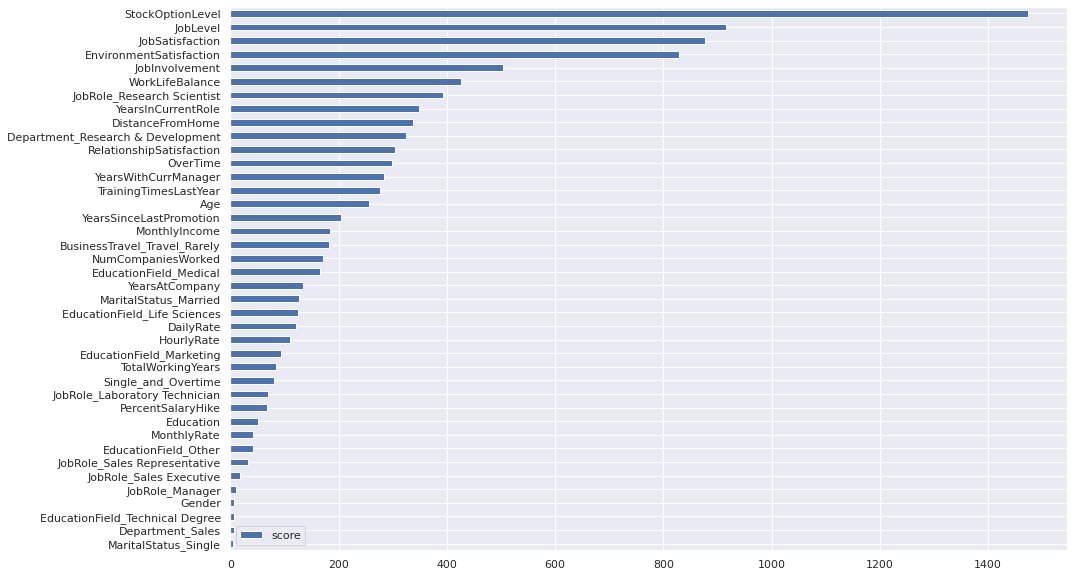

In [161]:
# The global 
feature_important = clf.get_booster().get_score(importance_type='total_gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"])
data.sort_values(by = "score", ascending=True).plot(kind='barh', figsize = (15,10));

### Key-findings are:
1. The global explainability shows a slightly result than the correlation analysis. Environment-Satisfaction is highly important, however it is a difficult feature to get and it might display the same information as Attrition. Hence in a real world and practical scenario, this feature can be neglected. Same applies to JobSatisfaction. 
2. Maybe also stockoption level has a similar pattern, when someone stays there for a longer time and is highly satisfied, one also buys stock from the company. The other explanation can be causality/direction, if someone bought stocks, one is willing to make the stocks more profitable and works longer and harder for the company. 
3. DistanceFromHome and Overtime also ar more important, the newly generated feature Single_and_Overtime however not.

#### 5.2. SHAP
SHAP values are a method of explainable AI that provides insight into the contribution of individual features to a model's prediction for a specific instance. With respect to tree-based classification algorithms, SHAP values help understand how a decision tree splits and assigns a prediction by assigning a contribution score to each feature that explains its impact on the final prediction. The contribution score of a feature can be either positive or negative and the sum of all the contribution scores adds up to the prediction made by the model. In other words, SHAP values provide a way to decompose a prediction made by a tree-based model into the contributions of individual features. The contribution scores assigned by SHAP values can also capture the interaction between features. A feature interaction occurs when the effect of one feature on the prediction depends on the value of another feature. For instance, consider a tree-based model for classifying fruit based on its color and size. The model might predict that a large red fruit is a watermelon, while a small red fruit is a cherry. In this case, the contribution scores assigned by the SHAP values would reflect the interaction between size and color, as the size of the fruit changes the impact of its color on the prediction.

In [163]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_smote)

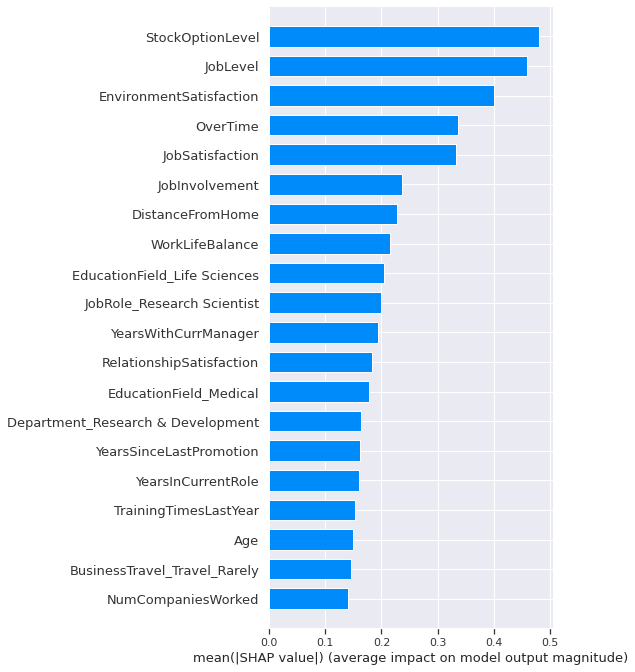

In [164]:
shap.summary_plot(shap_values, X_smote, plot_type="bar")

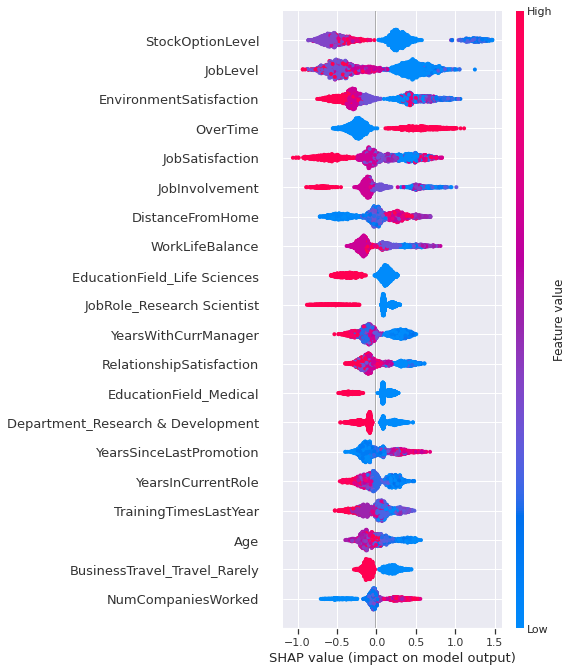

In [165]:
shap.summary_plot(shap_values, X_smote)

In [166]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_smote.iloc[0,:])